<a href="https://colab.research.google.com/github/s-whynot/Transfer_Learning_Bearing_Fault/blob/main/3_Classes_CWRU_to_MFPT_to_MFPT_Fault__Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Fault detection for rolling element bearings with Keras and Tensorflow using Transfer Learning

# 1.Introduction 
The 2 datasets that have been used here are - 
CWRU and MFPT

- The first dataset is from the [Case Western Reserve University](http://csegroups.case.edu/bearingdatacenter/home). This is used to classify faults using a CNN (Convolutional Neural Network). I have uploaded this data to [Github](https://github.com/s-whynot/CWRU-dataset). With this, I downloaded my own, verified, up-to-date (November 2020) CWRU bearing data. 

- [MFPT](https://www.mfpt.org/fault-data-sets/) Dataset for Bearing Fault Classification by the *Society for Machinery Failure Prevention Technology*. It is a Condition Based Maintenance Fault Database. It is meant for the purpose of Testing of Diagnostic and Prognostics Algorithms.
 

In [1]:
import errno, os
import requests
import scipy.io as sio
import numpy as np

from os import listdir
from os.path import isfile, join
from zipfile import ZipFile 

# 2.Download the dataset - CWRU

The dataset is downloaded from the [Github](https://github.com/s-whynot/CWRU-dataset) repository.  The dataset has several matlab files where the name is just a number (such as "118.mat"). It has information such as
1. **State** -
     - `N` for *normal* state, not damaged
     - `B` for *ball* damage
     - `IR` for *inner raceway* damage
     - `OR` for *outer raceway* damage
2. **Fault Diameter** -
    - `007` for 0.007 inch damage
    - `014` for 0.014 inch damage 
    - `021` for 0.021 inch damage
    - `028` for 0.028 inch damage  
    the unit 'mils' is 1/1000th of an inch
3. **Position of the sensor** 
    - *3*, *6*, *12* for *outer raceway* faults located at 3 o’clock, at 6 o’clock and at 12 o’clock respectively of the load zone
4. **Load** can be:
    - *0*, *1*, *2*, *3* for different motor load conditions in Horsepower (HP)

In [2]:
filename = os.path.join(os.getcwd(), 'repo.zip')
url = 'https://github.com/s-whynot/CWRU-dataset/archive/main.zip'

r = requests.get(url)
print(filename)
with open(filename, 'wb') as f:
    f.write(r.content) 

file_name = "/content/repo.zip"
with ZipFile(file_name, 'r') as zip: 
    # printing all the contents of the zip file 
  
    # extracting all the files 
    print('Extracting all the files now...') 
    zip.extractall() 
    print('Finished Extracting!') 

/content/repo.zip
Extracting all the files now...
Finished Extracting!


# 3.Edit the downloaded data

##3.1 Functions used

Using the data collected at the *Drive End*, which is labeled as the code `DE`, this function picks up the time signal from a file. For the given code, a regex is made on the dictionary keys, looking for the the code and ignoring the rest of the suffix. 

The function also converts the unit to SI.

In [3]:
def acceleration_time_signal(dict_1, code):
    """
    load the time series in the file and convert units in SI
    file= 'filename' from the ./dataset/ folder
    code= ' DE' or 'FE', other code will give error
    """
    import re
    try:
        for key in dict_1:
            if re.findall(rf"({code})", key):
                dict_code = key
        #inches to meter
        unit_conv = 0.0254
        x = dict_1[dict_code] * unit_conv
        return x
    except:
        print('File does not exist or code wrong. Code must be either "DE or "FE" ')

- 3 different functions are necessary to process the files and the data
- All subfolders scanned recursively with the function `fast_scandir` 

In [6]:
def Read_MAT_files_from_folders(file_path, files_list, code):
  G_data = []
  for i in range(len(files_list)):
    data = sio.loadmat(os.path.join(file_path, files_list[i]))
    sig = acceleration_time_signal(data, code)
    G_data.append(sig)
  
  G_data = np.vstack(G_data).flatten()
  return G_data 

def Percent_data_split(array_1, array_2, percent_1 = 10, index_1 = False):
  if index_1 == False:
    #splitting FE data by percent 
    len_n = array_1.shape[0]
    percent_true = percent_1/100
    x = int(percent_true*len_n) #% split
    data_percent, data_rest = np.split(array_1, [x])
  else:
    #splitting array_1 data by percent of array_2 data
    len_n = array_2.shape[0]
    percent_true = percent_1/100
    x = int(percent_true*len_n) #% split
    data_percent, data_rest = np.split(array_1, [x])

  return data_percent, data_rest

def fast_scandir(dirname):
    subfolders= [f.path for f in os.scandir(dirname) if f.is_dir()]
    for dirname in list(subfolders):
        subfolders.extend(fast_scandir(dirname))
    return subfolders 

##3.2 Source Domain 

### 3.2.1 Normal Acceleration data 
CWRU DE 

In [8]:
#12k Normal Signal for DE
file_path_1 = '/content/CWRU-dataset-main/Normal/'
onlyfiles_1 = [f for f in listdir(file_path_1) if isfile(join(file_path_1, f))]

G_data_N_DE = Read_MAT_files_from_folders(file_path_1, onlyfiles_1, "DE")
display(G_data_N_DE.shape)

(1698547,)

### 3.2.2 12000 Hz DE data for faults 
1. B, 
2. IR, 
3. OR

In [9]:
#12k DE data load
file_path_2 = '/content/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/'
subfolder_path = fast_scandir(file_path_2)

G_data_OR_007_DE = []
G_data_OR_021_DE = []

for i in range(3, len(subfolder_path), 1):
  dir_1 = subfolder_path[i]
  #B
  if 'B/' in dir_1:
    onlyfiles_2_1 = [f for f in listdir(dir_1) if isfile(join(dir_1, f))]

    if '007' in dir_1:
    #007
      G_data_B_007_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_1, "DE")
    elif '014' in dir_1:
    #014
      G_data_B_014_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_1, "DE")
    elif '021' in dir_1:
    #021
      G_data_B_021_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_1, "DE")
    else:
    #028
      G_data_B_028_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_1, "DE")
  #B
  #IR
  elif 'IR/' in dir_1:
    onlyfiles_2_2 = [f for f in listdir(dir_1) if isfile(join(dir_1, f))]

    if '007' in dir_1:
    #007
      G_data_IR_007_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_2, "DE")
    elif '014' in dir_1:
    #014
      G_data_IR_014_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_2, "DE")
    elif '021' in dir_1:
    #021
      G_data_IR_021_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_2, "DE")
    else:
    #028
      G_data_IR_028_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_2, "DE")
  #IR
  #OR
  elif 'OR/' in dir_1:
    onlyfiles_2_3 = [f for f in listdir(dir_1) if isfile(join(dir_1, f))]
    if '007' in dir_1:
      #007
      for i in range(len(onlyfiles_2_3)):
        data_OR_007 = sio.loadmat(os.path.join(dir_1, onlyfiles_2_3[i]))
        or_sig_007 = acceleration_time_signal(data_OR_007, code='DE')
        G_data_OR_007_DE.append(or_sig_007)
    elif '014' in dir_1:
      #014
      G_data_OR_014_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_3, "DE")
    else:
      #021
      for i in range(len(onlyfiles_2_3)):
        data_OR_021 = sio.loadmat(os.path.join(dir_1, onlyfiles_2_3[i]))
        or_sig_021 = acceleration_time_signal(data_OR_021, code='DE')
        G_data_OR_021_DE.append(or_sig_021)
  #OR 
print("G_data_B_007_DE", G_data_B_007_DE.shape)
print("G_data_B_014_DE", G_data_B_014_DE.shape)
print("G_data_B_021_DE", G_data_B_021_DE.shape)
print("G_data_B_028_DE", G_data_B_028_DE.shape)

print("G_data_IR_007_DE", G_data_IR_007_DE.shape)
print("G_data_IR_014_DE", G_data_IR_014_DE.shape)
print("G_data_IR_021_DE", G_data_IR_021_DE.shape)
print("G_data_IR_028_DE", G_data_IR_028_DE.shape)
G_data_IR_DE = np.concatenate((G_data_IR_007_DE, G_data_IR_014_DE, G_data_IR_021_DE, G_data_IR_028_DE), axis=0).flatten()
print("G_data_IR_DE", G_data_IR_DE.shape)

G_data_OR_007_DE = np.vstack(G_data_OR_007_DE).flatten()
print("G_data_OR_007_DE", G_data_OR_007_DE.shape)
G_data_OR_014_DE = np.vstack(G_data_OR_014_DE).flatten()
print("G_data_OR_014_DE", np.shape(G_data_OR_014_DE))
G_data_OR_021_DE = np.vstack(G_data_OR_021_DE).flatten()
print("G_data_OR_021_DE", G_data_OR_021_DE.shape)
G_data_OR_DE = np.concatenate((G_data_OR_007_DE, G_data_OR_014_DE, G_data_OR_021_DE), axis=0).flatten()
print("G_data_OR_DE", np.shape(G_data_OR_DE))      

G_data_B_007_DE (487093,)
G_data_B_014_DE (488109,)
G_data_B_021_DE (487964,)
G_data_B_028_DE (484120,)
G_data_IR_007_DE (488309,)
G_data_IR_014_DE (487239,)
G_data_IR_021_DE (487529,)
G_data_IR_028_DE (485038,)
G_data_IR_DE (1948115,)
G_data_OR_007_DE (1465051,)
G_data_OR_014_DE (487819,)
G_data_OR_021_DE (1465487,)
G_data_OR_DE (3418357,)


### 3.2.3 Plot - CWRU
Some signals are plotted for the position code = `DE` of the train data. The data is sampled at 12kHz, that is 12000 data points per second. Plot is done for 1/10 or 10% of 1 second: 

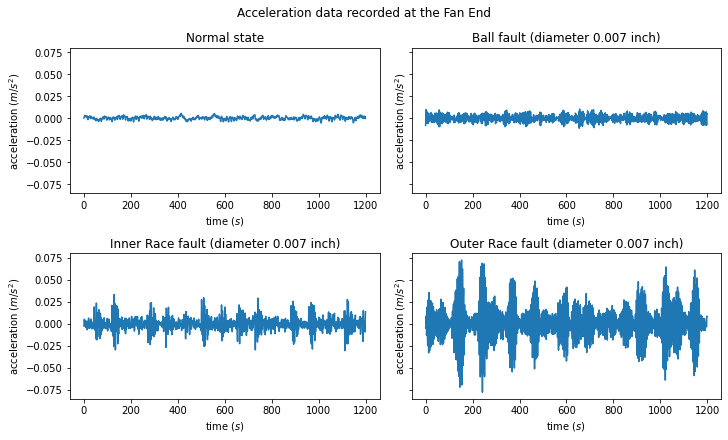

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

range_of_samples = range(0,1200)

# plotting
fig, axs = plt.subplots(2, 2, sharey=True, figsize=(10, 6), constrained_layout=True)
fig.suptitle('Acceleration data recorded at the Fan End')

axs[0, 0].plot(G_data_N_DE[range_of_samples])
axs[0, 0].set_title('Normal state')

axs[0, 1].plot(G_data_B_007_DE[range_of_samples])
axs[0, 1].set_title('Ball fault (diameter 0.007 inch)')

axs[1, 0].plot(G_data_IR_007_DE[range_of_samples])
axs[1, 0].set_title('Inner Race fault (diameter 0.007 inch)')

axs[1, 1].plot(G_data_OR_007_DE[range_of_samples])
axs[1, 1].set_title('Outer Race fault (diameter 0.007 inch)')

for ax in axs.flat:
    ax.set(xlabel='time $(s)$', ylabel='acceleration $(m/s^2)$')


##3.3 Transfer Domain 
 

Loading the MFPT dataset


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 3.3.1 Functions used 2
*Functions* used


In [13]:
#Function for extracting g data array from the dictionary read from Mat files
def arrtolistgdataALT(matarr):
  p11 = matarr['bearing'][:,0]['gs']
  return p11[0]

def Percent_split(array_1, percent = 1):
  len_n = len(array_1)
  percent_true = percent/100
  x = int(percent_true*len_n) #% split
  data_percent, data_rest = np.split(array_1, [x])

  return data_percent, data_rest

#Function for downsampling every window of g data array
def downsampling_half_sec_window(Garr, no_of_windows_in_sec):
  Arr_split = np.split(Garr, no_of_windows_in_sec)
  down_sampled_all = []
  for i in range(no_of_windows_in_sec):
    down_sampled = Arr_split[i][::2]
    down_sampled_all = np.append(down_sampled_all, down_sampled)
  res1 = np.vstack(down_sampled_all) 
  return res1

### 3.3.2 Nominal "No Fault" Data
3 Baseline conditions -

1.   Constant load of 270 lbs 
2.   Input Shaft Rate of 25 Hz
3.   Sampling Rate of 97.656 kHz


In [14]:
file_path = 'drive/My Drive/MFPT Fault Data Sets/1 - Three Baseline Conditions/'
onlyfiles = [f for f in listdir(file_path) if isfile(join(file_path, f))]

#Reading data from folder
Nominal_data = []
for filename in os.listdir(file_path):
  if filename.endswith('.mat'):
    datadict = sio.loadmat(os.path.join(file_path, filename))
    time = datadict['__header__'][50:]
    Gdata = arrtolistgdataALT(datadict)
    Nominal_data.append(Gdata)   
       
Nominal_data = np.vstack(Nominal_data).flatten()

In [15]:
p1 = datadict['bearing']['sr'].tolist()
psr_1 = p1[0][0][0][0]
print("The Sampling Rate in Hz: ", psr_1)
p111 = datadict['bearing'][:, 0]['load'].tolist()
print("Baseline Data for a Constant load in lbs: ", p111[0].tolist()[0][0])

The Sampling Rate in Hz:  97656
Baseline Data for a Constant load in lbs:  270


### 3.3.3 Outer Race(OR) Fault conditions

#### 3 Outer Race(OR) Fault conditions 
1.   constant load of 270 lbs 
2.   Input Shaft Rate of 25 Hz
3.   Sampling Rate of 97.656 kHz

**Simply skip every other samples to reduce the sampling rate to half**


*   3 files - total 1,757,808 data points
*   Each file - dimension (585936, 1)
*   585,936 / 6 seconds = 97656 Sampling rate in Hz
*   97656 X 1 =  97,656
*   97656 X 2 = 195,312
*   97656 X 3 = 292,968
*   97656 X 4 = 390,624
*   97656 X 5 = 488,280
*   97656 X 6 = 585,936

---

After skipping every 2 steps - 

*   97,656 / 2 = 48,828
*   For each 6 windows = 48,828 * 6 = 292,968 in a single file
*   For 3 files = 292,968 * 3  = 878,904

Now sampling rate for both OR data same






In [17]:
#The files present in the folder
file_path_2 = 'drive/My Drive/MFPT Fault Data Sets/2 - Three Outer Race Fault Conditions/'
onlyfiles_2 = [f for f in listdir(file_path_2) if isfile(join(file_path_2, f))]
print(onlyfiles_2)

Fixed_L_OR_data = []

for filename_2 in os.listdir(file_path_2):
  if filename_2.endswith('.mat'):
    datadict_2 = sio.loadmat(os.path.join(file_path_2, filename_2))
    time_2 = datadict_2['__header__'][50:]
    Gdata_2 = arrtolistgdataALT(datadict_2)
    Gdata_2_Edit = downsampling_half_sec_window(Gdata_2, 6)
    Fixed_L_OR_data.append(Gdata_2_Edit)

Fixed_L_OR_data = np.vstack(Fixed_L_OR_data).flatten()

['cyclostat.tif', 'OuterRaceFault_1.mat', 'OuterRaceFault_2.mat', 'OuterRaceFault_3.mat']


In [18]:
p2 = datadict_2['bearing']['sr'].tolist()
psr_2 = p2[0][0][0][0]
print("The Sampling Rate in Hz: ", psr_2)

The Sampling Rate in Hz:  97656


#### 7 Outer Race(OR) conditions 
1.   Variable loads of 25, 50, 100, 150, 200, 250 and 300 lbs 
2.   Input Shaft Rate of 25 Hz
3.   Sampling Rate of 48.828 kHz for 3 seconds 

Merging the **fixed load, high Sampling Rate(SR)** OR data with the **variable load, lower SR OR data**.
Sampling rate is same for both OR data - 

In [19]:
#The files present in the folder
file_path_3 = 'drive/My Drive/MFPT Fault Data Sets/3 - Seven More Outer Race Fault Conditions/'
onlyfiles_3 = [f for f in listdir(file_path_3) if isfile(join(file_path_3, f))]
print(onlyfiles_3)

Var_L_OR_data = []

for filename_3 in os.listdir(file_path_3):
     if filename_3.endswith('.mat'):
       datadict_3 = sio.loadmat(os.path.join(file_path_3, filename_3))
       time_3 = datadict_3['__header__'][50:]
       Gdata_3 = arrtolistgdataALT(datadict_3)
       Var_L_OR_data.append(Gdata_3)

Var_L_OR_data = np.vstack(Var_L_OR_data).flatten()
merged_G_OR_data = np.append(Var_L_OR_data, Fixed_L_OR_data)

['OuterRaceFault_vload_3.mat', 'OuterRaceFault_vload_2.mat', 'OuterRaceFault_vload_1.mat', 'OuterRaceFault_vload_5.mat', 'OuterRaceFault_vload_4.mat', 'OuterRaceFault_vload_6.mat', 'OuterRaceFault_vload_7.mat']


In [20]:
p3 = datadict_3['bearing']['sr'].tolist()
psr_3 = p3[0][0][0][0]
print("The Sampling Rate in Hz: ", psr_3)

The Sampling Rate in Hz:  48828


### 3.3.4 7 Inner Race(IR) conditions 

1. Variable loads of 0, 50, 100, 150, 200, 250 and 300 lbs
2. Input Shaft Rate of 25 Hz
3. Sampling Rate of 48.828 kHz for 3 seconds 

In [21]:
#The files present in the folder
file_path_4 = 'drive/My Drive/MFPT Fault Data Sets/4 - Seven Inner Race Fault Conditions/'
onlyfiles_4 = [f for f in listdir(file_path_4) if isfile(join(file_path_4, f))]
print(onlyfiles_4)

IR_data = []
for filename_4 in os.listdir(file_path_4):
     if filename_4.endswith('.mat'):
       datadict_4 = sio.loadmat(os.path.join(file_path_4, filename_4))
       time_4 = datadict_4['__header__'][50:]
       Gdata_4 = arrtolistgdataALT(datadict_4)
       IR_data.append(Gdata_4)

IR_data = np.vstack(IR_data).flatten()

['innerRaceFaultTime.tif', 'innerRaceFaultTime.png', 'innerRaceFaultTime.fig', 'InnerRaceFault_vload_3.mat', 'InnerRaceFault_vload_2.mat', 'InnerRaceFault_vload_1.mat', 'InnerRace.fig', 'InnerRaceFault_vload_5.mat', 'InnerRaceFault_vload_4.mat', 'InnerRaceFault_vload_6.mat', 'InnerRaceFault_vload_7.mat']


In [22]:
p4 = datadict_4['bearing']['sr'].tolist()
psr_4 = p4[0][0][0][0]
print("The Sampling Rate in Hz: ", psr_4)

The Sampling Rate in Hz:  48828


### 3.3.5 Train 2 and Test Split
Separating 10%-90% for Train-Test, this split is for **Transfer Learning**
1. Nominal - 10%
2. Outer Race - 10%
3. Inner Race - 10%

In [23]:
Nominal_data_train, Nominal_data_test = Percent_data_split(Nominal_data, Nominal_data, percent_1 = 10, index_1 = False)
print("Nominal_data_train", Nominal_data_train.shape)
print("Nominal_data_test", Nominal_data_test.shape)

IR_data_train, IR_data_test =  Percent_data_split(IR_data, IR_data, percent_1 = 10, index_1 = False)
print("IR_data_train", IR_data_train.shape)
print("IR_data_test", IR_data_test.shape)

OR_data_train, OR_data_test =  Percent_data_split(merged_G_OR_data, merged_G_OR_data, percent_1 = 10, index_1 = False)
print("OR_data_train", OR_data_train.shape)
print("OR_data_test", OR_data_test.shape)

Nominal_data_train (175780,)
Nominal_data_test (1582028,)
IR_data_train (102538,)
IR_data_test (922850,)
OR_data_train (190429,)
OR_data_test (1713863,)


### 3.3.6 Sampling rates fraction
Processing the 2 different sampling rates - 97 kHz and 48 kHz by taking 1/10 of each

In [24]:
rounded_psr_2 = int(psr_1/10)
range_of_samples_2 = range(0, rounded_psr_2)
rounded_psr_3 = int(psr_3/10)
range_of_samples_3 = range(0, rounded_psr_3)

### 3.3.7 Acceleration data Plot - MFPT

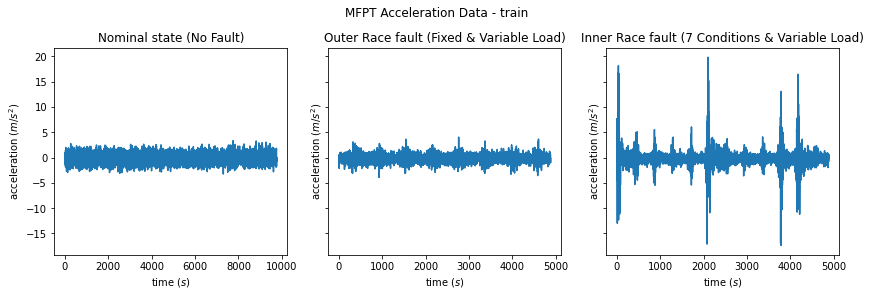

In [25]:
fig, (plt1, plt2, plt3) = plt.subplots(1, 3, sharey = True, figsize=(12,4), constrained_layout=True)

plt1.set_xlabel("time $(s)$")
plt1.set_ylabel("acceleration $(m/s^2)$")
plt1.set_title('Nominal state (No Fault)')
plt1.plot(Nominal_data_train[range_of_samples_2])

plt2.set_xlabel("time $(s)$")
plt2.set_ylabel("acceleration $(m/s^2)$")
plt2.set_title('Outer Race fault (Fixed & Variable Load)')
plt2.plot(OR_data_train[range_of_samples_3])

plt3.set_xlabel("time $(s)$")
plt3.set_ylabel("acceleration $(m/s^2)$")
plt3.set_title('Inner Race fault (7 Conditions & Variable Load)')
plt3.plot(IR_data_train[range_of_samples_3])

fig.suptitle('MFPT Acceleration Data - train')
fig.show()

# 4.Preprocessing and the architecture of the CNN


This has been accomplished with the help of [this Github rep](https://github.com/dimitardi/deep-predict). 

The different preprocessing phases are - 

1. Data in chunks
2. Feature engineering
3. Image creating
4. Image loading
5. Data shuffling
6. Convolutional Neural Network (CNN)

## 4.1 Data in chunks

1. Acceleration data or signal is divided in chunks of size `chunk_size` and a subset `number_of_chunks` from all of it that is available for training and testing the CNN. 

2. A chunk is simply a sequential subset of the time series data with a fixed length - the `chunk_size`. 

3. Every chunk is distinct - no overlapping samples. 

4. This method is _tumbling time windowing_, more information in [blog post](https://blog.codecentric.de/en/2018/10/window-functions-in-stream-analytics/). 

5. Each time series is an array, with small length differences. For a fixed chunk size to divide the file, a function will split the data exactly in `number_of_chunks` of `chunk_size` and **ignore** the remaining part. 

6. Such a function is - `split_exact`, which takes the *array for splitting*, the *number of chunks* and the *array axis* to be split into. 

7. Whole dataset remains but the vector has been divided into column chunks to build a matrix. It makes passing the **whole dataset** through easier and takes **less time** for the data to load in general.

In [26]:
def split_exact(x, n_chunks=2, axis=1):
    import numpy as np
    l = np.shape(x)[axis]
    x_split = x
    if l > n_chunks > 1:
        n = n_chunks
        if axis == 0:
            x_split = np.split(x[:-(l % n)], n, axis=axis)
        elif axis == 1:
            x_split = np.split(x[:, :-(l % n)], n, axis=axis)
    return x_split

Some operations were performed on the data. 

For the CWRU Data only - ignoring the 0.028 inch fault diameter from `IR` and `B`, only considering the rest:

* the **normal** data labelled as `N` - Baseline
* the **inner raceway** data labelled as `IR`
      1.for 0.007 inch fault diameter
      2.for 0.014 inch fault diameter
      3.for 0.021 inch fault diameter
* the **ball** data labelled as `B`
      1.for 0.007 inch fault diameter
      2.for 0.014 inch fault diameter
      3.for 0.021 inch fault diameter
* the **outer raceway** data labelled as `OR`
      1.for 0.007 inch fault diameter
      2.for 0.014 inch fault diameter
      3.for 0.021 inch fault diameter

For every load, the data is joined from `0...3` HP load, normalizing it with respect to the *standard deviation*. This is because the load is not considered in *Classification*. 

Several functions needed, such as; `load_raw_matlab_data` which returns several multidimensional arrays for `N`, `IR`, `B` and `OR` data with dimension of the maximum `number_of_chunks` obtainable from the data, by `chunk_size`. 

In [27]:
import numpy as np

def g_data_chunkSplit(gdata, chunk_size=128):
    """
    Change loaded mat files and splits it in chunks of size chunk_size
    """
    y_n: ndarray = np.array([])
    # signal
    x = gdata
    x = x / np.std(x)
    y_n = np.append(y_n, x)
    n_splits = len(y_n) // chunk_size
    y_n = split_exact(y_n, n_chunks=n_splits, axis=0)

    return y_n

Initializing the data using the latter function.

### 4.1.1 Source Domain data chunk
CWRU 12k DE data. To match the number of classes of MFPT, the `Ball` Class was ignored completely.



In [28]:
chunk_size_1 = 1200
number_of_chunks_1 = 1400

#DE data
normal_data_chunk_DE = g_data_chunkSplit(G_data_N_DE, chunk_size=chunk_size_1)
display("DE")
print("normal_data_chunk_DE", np.shape(normal_data_chunk_DE)) 
ir_data_chunk_DE = g_data_chunkSplit(G_data_IR_DE, chunk_size=chunk_size_1)
print("ir_data_chunk_DE", np.shape(ir_data_chunk_DE))
or_data_chunk_DE = g_data_chunkSplit(G_data_OR_DE, chunk_size=chunk_size_1)
print("or_data_chunk_DE", np.shape(or_data_chunk_DE)) 

'DE'

normal_data_chunk_DE (1415, 1200)
ir_data_chunk_DE (1623, 1200)
or_data_chunk_DE (2848, 1200)


### 4.1.2 Transfer Domain data chunk
For the MFPT data. Two different `chunk sizes` and `number of chunks` as there are two different SRs.

In [29]:
chunk_size_2 = rounded_psr_2
print("Chunk size for the Sampling Rate 1", chunk_size_2)
number_of_chunks_2 = chunk_size_2 + 200

chunk_size_3 = rounded_psr_3
print("Chunk size for the Sampling Rate 2", chunk_size_3)
number_of_chunks_3 = chunk_size_3 + 200

nominal_data_chunk_train = g_data_chunkSplit(Nominal_data_train, chunk_size=chunk_size_2)
print("nominal_data_chunk_train", np.shape(nominal_data_chunk_train))
ir_data_chunk_train =  g_data_chunkSplit(IR_data_train, chunk_size=chunk_size_3)
print("ir_data_chunk_train", np.shape(ir_data_chunk_train)) 
or_data_chunk_train =  g_data_chunkSplit(OR_data_train, chunk_size=chunk_size_3)
print("or_data_chunk_train", np.shape(or_data_chunk_train)) 

nominal_data_chunk_test = g_data_chunkSplit(Nominal_data_test, chunk_size=chunk_size_2)
print("nominal_data_chunk_test", np.shape(nominal_data_chunk_test)) 
ir_data_chunk_test =  g_data_chunkSplit(IR_data_test, chunk_size=chunk_size_3)
print("ir_data_chunk_test", np.shape(ir_data_chunk_test))
or_data_chunk_test =  g_data_chunkSplit(OR_data_test, chunk_size=chunk_size_3)
print("or_data_chunk_test", np.shape(or_data_chunk_test))

Chunk size for the Sampling Rate 1 9765
Chunk size for the Sampling Rate 2 4882
nominal_data_chunk_train (18, 9765)
ir_data_chunk_train (21, 4882)
or_data_chunk_train (39, 4882)
nominal_data_chunk_test (162, 9765)
ir_data_chunk_test (189, 4882)
or_data_chunk_test (351, 4882)


## 4.2 Feature engineering

Each chunk of data is preprocessed. A time-frequency image is extracted from each *chunk* with preprocessing techniques. For all the images, a **min-max normalization** was used, to have the mapping only in the range `[0,1]`.

In [30]:
def min_max_norm(ary):
    ary = (ary - ary.min()) / np.abs(ary.max() - ary.min())
    return ary

### 4.2.1 Short Time Fourier Transform
The function `generate_spectrogram_image(data_y_vector, image_shape)` takes a *time series* as input and the *resolution* of the image that it will generate. It then returns the **Short time Fourier Transform Spectrogram** which is then *normalized* in the range `[0,1]`.

In [31]:
from scipy import signal
from skimage.transform import resize

def generate_spectrogram_image(data_y_vector, image_shape, fs):
    """
    Calculate the spectrogram of an array data_y_vector and resize it in 
    the image_shape resolution
    """
    data_y_vector_len = np.shape(data_y_vector)[0]

    f, t, sxx = signal.spectrogram(
        data_y_vector,
        fs)

    sxx = min_max_norm(sxx)
    sxx = resize(sxx, image_shape, mode='constant', anti_aliasing=True)

    return sxx

A look at the Short Time Fourier Transform of one chunk of the data `N`, `IR`, `B` and `OR`. From the **MFPT train** set:

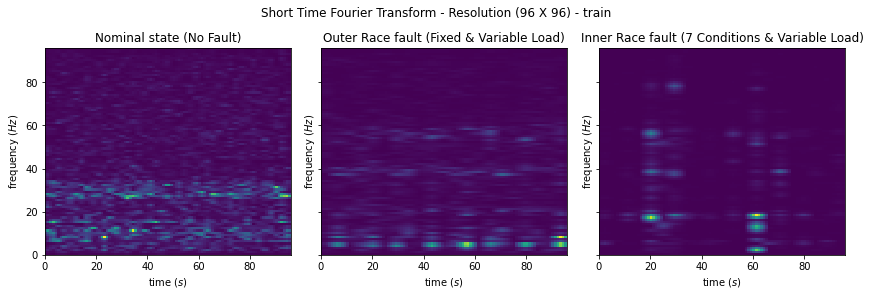

In [32]:
fig, (plt1, plt2, plt3) = plt.subplots(1, 3, sharey = True, figsize=(12,4), constrained_layout=True)

plt1.set_xlabel("time $(s)$")
plt1.set_ylabel("frequency $(Hz)$")
plt1.set_title('Nominal state (No Fault)')
plt1.pcolormesh(generate_spectrogram_image(nominal_data_chunk_train[1], (96, 96), psr_1), shading='flat')

plt2.set_xlabel("time $(s)$")
plt2.set_ylabel("frequency $(Hz)$")
plt2.set_title('Outer Race fault (Fixed & Variable Load)')
plt2.pcolormesh(generate_spectrogram_image(or_data_chunk_train[1], (96, 96), psr_3), shading='flat')

plt3.set_xlabel("time $(s)$")
plt3.set_ylabel("frequency $(Hz)$")
plt3.set_title('Inner Race fault (7 Conditions & Variable Load)')
plt3.pcolormesh(generate_spectrogram_image(ir_data_chunk_train[1], (96, 96), psr_3), shading='flat')

fig.suptitle('Short Time Fourier Transform - Resolution (96 X 96) - train')
fig.show()

## 4.3 Image creating and Data shuffling

Several images are created that are going to be used to train the CNN. Some functions are needed to help in creating the folders in which the images will be stored and to label correctly the files generated, depending on the parameters chosen, such as `position`, `image_type`, `image_shape`, etc. 

A random shuffling is done between the chunks at this stage, so the CNN does not get trained on images that are of adjacent time windows.

### 4.3.1 Directory 
Creating directory for putting the created images. These images will also be loaded from here.

In [33]:
def try_make_directories():     
    data_directories = ["dataset", "npy_dataset"]
    for directory in data_directories:
        try:
            os.makedirs(f'./{directory}')
        except OSError as e:
            if e.errno != errno.EEXIST:
                raise

The function `generate_rgba_images_from_data` has been called separately for DE as the Sampling Rate is different

In [34]:
from tqdm.notebook import tqdm
from enum import Enum
#
def create_image_by_label_database(
        position,
        image_types,
        image_shape,
        noise_scale = 0.0,
        shuffle_across_time=True,
        overwrite_existing_file=False):

    try_make_directories()

    filename_for_images_by_labels = npy_dataset_filename(
        position,
        image_types,
        image_shape,
        noise_scale, 
        shuffle_across_time
    )

    if overwrite_existing_file is False:
        import os
        if os.path.isfile(filename_for_images_by_labels):
            print(
                "File already exists. Use 'overwrite_existing_file' if you wish to regenerate and overwrite it. Bye.")
            return
#   
    if position == "DE":
      len_n = np.shape(normal_data_chunk_DE)[0]
      len_ir = np.shape(ir_data_chunk_DE)[0]
      len_or = np.shape(or_data_chunk_DE)[0]
      
      len_data = min(len_n, len_ir, len_or, number_of_chunks_1)

      normal_data = normal_data_chunk_DE
      ir_data = ir_data_chunk_DE
      or_data = or_data_chunk_DE

      if shuffle_across_time:
          # so the first N chunks will be taken at random time from the whole time window
          np.random.shuffle(normal_data)
          np.random.shuffle(ir_data)
          np.random.shuffle(or_data)
        
      images_by_labels = {'n': [], 'ir': [], 'or': []}
      #1
      for i in tqdm(range(int(len_n))):
          n_images = generate_rgba_images_from_data(normal_data[i], image_shape, image_types, 12000)

          images_by_labels['n'].extend(n_images)
      #2
      for i in tqdm(np.arange(len_ir)):
          ir_images = generate_rgba_images_from_data(ir_data[i], image_shape, image_types, 12000)
        
          images_by_labels['ir'].extend(ir_images)
      #3
      for i in tqdm(np.arange(len_or)):    
          or_images = generate_rgba_images_from_data(or_data[i], image_shape, image_types, 12000)
        
          images_by_labels['or'].extend(or_images)

    elif position == "MFPT_train":
      len_n = np.shape(nominal_data_chunk_train)[0]
      len_ir = np.shape(ir_data_chunk_train)[0]
      len_or = np.shape(or_data_chunk_train)[0]
      len_data = min(len_n, len_or, len_ir, number_of_chunks_2, number_of_chunks_3)
      
      nominal_data = nominal_data_chunk_train
      ir_data = ir_data_chunk_train
      or_data = or_data_chunk_train

    elif position == "MFPT_validation":
      len_n = np.shape(nominal_data_chunk_val)[0]
      len_ir = np.shape(ir_data_chunk_val)[0]
      len_or = np.shape(or_data_chunk_val)[0]
      len_data = min(len_n, len_or, len_ir, number_of_chunks_2, number_of_chunks_3)
     
      nominal_data = nominal_data_chunk_val
      ir_data = ir_data_chunk_val
      or_data = or_data_chunk_val

    elif position == "MFPT_test":
      len_n = np.shape(nominal_data_chunk_test)[0]
      len_ir = np.shape(ir_data_chunk_test)[0]
      len_or = np.shape(or_data_chunk_test)[0]
      len_data = min(len_n, len_or, len_ir, number_of_chunks_2, number_of_chunks_3)
      
      nominal_data = nominal_data_chunk_test
      ir_data = ir_data_chunk_test
      or_data = or_data_chunk_test

    if 'MFPT' in position:
      if shuffle_across_time:
        # so the first N chunks will be taken at random time from the whole time window
        np.random.shuffle(nominal_data)
        np.random.shuffle(ir_data)
        np.random.shuffle(or_data)
        
      images_by_labels = {'n': [], 'ir': [], 'or': []}
    
      for i in tqdm(range(int(len_n))):
          n_images = generate_rgba_images_from_data(nominal_data[i], image_shape, image_types, psr_1)

          images_by_labels['n'].extend(n_images)

      for i in tqdm(range(int(len_ir))):
          ir_images = generate_rgba_images_from_data(ir_data[i], image_shape, image_types, psr_3)  

          images_by_labels['ir'].extend(ir_images)

      for i in tqdm(range(int(len_or))):
          or_images = generate_rgba_images_from_data(or_data[i], image_shape, image_types, psr_3)      

          images_by_labels['or'].extend(or_images)

    print(f'Saving {filename_for_images_by_labels}')
    np.save(f'{filename_for_images_by_labels}', images_by_labels)
        
#
def npy_dataset_filename(
        position,
        image_types,
        image_shape,
        noise_scale,
        shuffled_across_time):
    filename_suffix = \
        (f'_Position_{position}') + \
        f'_types{"-".join([str(t)[10:12] for t in image_types])}' + \
        (f'_noise{noise_scale}' if noise_scale > 0 else '') + \
        (f'_timeshuffled' if shuffled_across_time else '') + \
        f'_shape{image_shape[0]}-{image_shape[1]}'
    filename = f'./npy_dataset/images_by_labels_for_cnn{filename_suffix}.npy'
    return filename
#
#
def generate_rgba_images_from_data(
        vector_y_data,
        image_shape,
        image_types,
        fsa):
    images = []
    if ImageType.SPECTROGRAM in image_types:
        images.append(generate_spectrogram_image(vector_y_data, image_shape, fsa))

    images_rgba = ary_to_rgba(images)

    return images_rgba
#
#
def ary_to_rgba(ary, nchannels=1):
    from matplotlib import cm

    ary_dim = (np.shape(ary))

    im = np.empty(shape=(ary_dim[0], ary_dim[1], ary_dim[2], nchannels)).astype('uint8')
    for i in np.arange(0, len(ary)):
        im[i, :] = np.log(ary[i] + 1e-6).reshape(ary_dim[0], ary_dim[1], ary_dim[2], nchannels)
    return im
#

class ImageType(Enum):
    SCALOGRAM = 1
    SPECTROGRAM = 2
    QTRANSFORM = 3

### 4.3.2 Image creating
The parameters of the preprocessing are: 

Transfer Learning 
- Source Domain = 12k DE data for train

In [35]:
create_image_by_label_database(
    position="DE", 
    image_types=[ImageType.SPECTROGRAM], 
    image_shape=(96, 96), 
    shuffle_across_time=True,
    overwrite_existing_file=True)


Saving ./npy_dataset/images_by_labels_for_cnn_Position_DE_typesSP_timeshuffled_shape96-96.npy


Transfer Learning 
- Target Domain = 10% MFPT data for Train 2

In [36]:
create_image_by_label_database(
    position="MFPT_train", 
    image_types=[ImageType.SPECTROGRAM], 
    image_shape=(96, 96), 
    shuffle_across_time=True,
    overwrite_existing_file=True)


Saving ./npy_dataset/images_by_labels_for_cnn_Position_MFPT_train_typesSP_timeshuffled_shape96-96.npy


Transfer Learning 
- Target Domain = 90% MFPT data for Test

In [37]:
create_image_by_label_database(
    position="MFPT_test", 
    image_types=[ImageType.SPECTROGRAM], 
    image_shape=(96, 96), 
    shuffle_across_time=True,
    overwrite_existing_file=True)


Saving ./npy_dataset/images_by_labels_for_cnn_Position_MFPT_test_typesSP_timeshuffled_shape96-96.npy


## 4.4 Preparing Train-Test Data 

### 4.4.1 Image loading
Now to define a function that loads the images that were generated.


In [38]:
def load_images_by_labels_by_params(
        position,
        image_types ,
        image_shape,
        noise_scale = 0.0,
        chunks_are_shuffled_across_time=True):
    filename = npy_dataset_filename(
        position,
        image_types,
        image_shape,
        noise_scale,
        chunks_are_shuffled_across_time)

    loaded = np.load(filename, allow_pickle=True)
    print(f"Successfully loaded file {filename}")
    return loaded.item()  # item() gets the actual dictionary from the loaded object

With the aid of the previous function the images for *DE* and *train* is loaded

In [39]:
position = "DE"
image_types=[ImageType.SPECTROGRAM]
image_shape = (96, 96)
shuffle_chunks_across_time=True

images_by_labels_for_cnn_train_1 = load_images_by_labels_by_params(
    position=position,    
    image_types=image_types, 
    image_shape=image_shape,
    chunks_are_shuffled_across_time=shuffle_chunks_across_time)

Successfully loaded file ./npy_dataset/images_by_labels_for_cnn_Position_DE_typesSP_timeshuffled_shape96-96.npy


With the aid of the previous function the images for *MFPT* and *train* is loaded. This is the *train split* of 10%.

In [40]:
position = "MFPT_train"
image_types=[ImageType.SPECTROGRAM]
image_shape = (96, 96)
shuffle_chunks_across_time=True

images_by_labels_for_cnn_train_2 = load_images_by_labels_by_params(
    position=position,    
    image_types=image_types, 
    image_shape=image_shape,
    chunks_are_shuffled_across_time=shuffle_chunks_across_time)

Successfully loaded file ./npy_dataset/images_by_labels_for_cnn_Position_MFPT_train_typesSP_timeshuffled_shape96-96.npy


With the aid of the previous function the images for *MFPT* and *test* is loaded. This is the *test split* of 90%.

In [41]:
position = "MFPT_test"
image_types=[ImageType.SPECTROGRAM]
image_shape = (96, 96)
shuffle_chunks_across_time=True

images_by_labels_for_cnn_test = load_images_by_labels_by_params(
    position=position,    
    image_types=image_types, 
    image_shape=image_shape,
    chunks_are_shuffled_across_time=shuffle_chunks_across_time)

Successfully loaded file ./npy_dataset/images_by_labels_for_cnn_Position_MFPT_test_typesSP_timeshuffled_shape96-96.npy


### 4.4.2 Image separation
Now, to transform the data to be suitable for the CNN input:
- the images and their labels need to be separated into two arrays, correlated by their indices
- the labels are to be one-hot encoded (i.e. label "N" becomes (0,0,1))


In [43]:
from itertools import zip_longest

def separate_images_from_labels(images_by_labels, interleave: bool):
    all_labels = list(images_by_labels.keys())
    
    NB_CLASSES = len(all_labels)
    all_labels_onehot = np.identity(NB_CLASSES).astype('uint8')
    label_to_onehot_mapper = {all_labels[i]: all_labels_onehot[i] for i in np.arange(NB_CLASSES)}

    all_images_for_cnn = []
    all_labels_for_cnn_onehot = []

    for key in all_labels:
        images = images_by_labels[key]
        labels_onehot = np.full(shape=(len(images), NB_CLASSES), fill_value=label_to_onehot_mapper[key])

        all_images_for_cnn.append(images)
        all_labels_for_cnn_onehot.append(labels_onehot)

    if interleave:
        all_images_for_cnn = lists_interleave(all_images_for_cnn)
        all_labels_for_cnn_onehot = lists_interleave(all_labels_for_cnn_onehot)
    else:  # flatten the lists
        all_images_for_cnn = [image for sublist in all_images_for_cnn for image in sublist]
        all_labels_for_cnn_onehot = [label for sublist in all_labels_for_cnn_onehot for label in sublist]

    return np.array(all_images_for_cnn), np.array(all_labels_for_cnn_onehot)
                               
def lists_interleave(lists):
    return [val for tup in zip(*lists) for val in tup]

The last step before training is to separate the *training set* and the *testing set* "images with labels" into the images and their corresponding labels.

In [44]:
images_train_1, labels_train_1_onehot = separate_images_from_labels(images_by_labels_for_cnn_train_1, interleave=False)
images_train_2, labels_train_2_onehot = separate_images_from_labels(images_by_labels_for_cnn_train_2, interleave=False)
images_test, labels_test_onehot = separate_images_from_labels(images_by_labels_for_cnn_test, interleave=False)

### 4.4.3 Image and label shuffling
Additionally, for a good distribution of data types accross the training and test data, the data is interleaved. It is for all of the 3 types of data and random shuffle is done while keeping the labels for values intact.

A single array is taken, containing all the images, where sequential images are always of a different data type (N, IR, B, OR) in the form [..., "N", "IR", "OR", "N", "IR",...].

In [46]:
random_idx = np.random.permutation(np.arange(0,images_train_1.shape[0]))
random_idx_2 = np.random.permutation(np.arange(0,images_train_2.shape[0]))
random_idx_test = np.random.permutation(np.arange(0,images_test.shape[0]))

In [47]:
images_train_1 = images_train_1[random_idx]
labels_train_1_onehot = labels_train_1_onehot[random_idx]
images_train_2 = images_train_2[random_idx_2]
labels_train_2_onehot = labels_train_2_onehot[random_idx_2]
images_test = images_test[random_idx_test]
labels_test_onehot = labels_test_onehot[random_idx_test]

## 4.5 **Convolutional Neural Network**
The CNN architecture used in this notebook is from the paper [Deep Learning Enabled Fault Diagnosis Using Time-Frequency Image Analysis of Rolling Element Bearings](https://www.hindawi.com/journals/sv/2017/5067651/). It is a proposed architecture. 
This architecture is used due to the resolution of the image and it yields very good results in terms of precision.

### 4.5.1 CNN model with Keras
It is a supervised classification problem, with 10 classes. A Convolutional Neural Network (CNN) is implemented as a **Sequential Keras model**. This **Keras model** uses **TensorFlow** as backend for the tensor arithmetics. 

The images that were previously generated, form a tuple `(number of images, x dpi, y dpi, number of channels)`. The *loss function* is **categorical cross-entropy**, the *optimizer* is **ADAM** and **Leaky RELU** is the *activation function* used after each Convolution layer. The *learning rate* has been tested to different values and in the end **learning rate decay** was followed manually for that matter.

In [48]:
from keras import optimizers

## input data parameters
IMAGES_SHAPE = (96, 96, 1)
PADDING = 'same'
KERNEL_SIZE = (3, 3)
KERNEL_INITIALIZER = 'glorot_normal'
# parameters for deep layers
NUMBER_OF_CLASSES = 3  #N, IR, OR
DROPOUT = 0.5
LEAK_ALPHA = 0.1
MAX_POOLING_POOL_SIZE = (2, 2)
ACTIVATION_LAYER_FUNCTION = 'softmax'
# loss and optimizer
LOSS_FUNCTION = 'categorical_crossentropy'
LEARNING_RATE = 3e-4 #1e-3 is the default!
OPTIMIZER = optimizers.Adam(epsilon=10e-6)

In [50]:
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import LeakyReLU
from keras import metrics


# CNN architecture from Guo et al.
model = Sequential()
model.add(Conv2D(32, KERNEL_SIZE,                  
                 input_shape=IMAGES_SHAPE,
                 data_format='channels_last',
                 kernel_initializer=KERNEL_INITIALIZER,                 
                 padding=PADDING))
model.add(LeakyReLU(LEAK_ALPHA))
model.add(Conv2D(32, KERNEL_SIZE, 
                 kernel_initializer=KERNEL_INITIALIZER,
                 padding=PADDING))
model.add(LeakyReLU(LEAK_ALPHA))
model.add(MaxPooling2D(pool_size=MAX_POOLING_POOL_SIZE))
model.add(Conv2D(64, KERNEL_SIZE, 
                 kernel_initializer=KERNEL_INITIALIZER,
                 padding=PADDING))
model.add(LeakyReLU(LEAK_ALPHA))
model.add(Conv2D(64, KERNEL_SIZE, 
                 kernel_initializer=KERNEL_INITIALIZER,
                 padding=PADDING))
model.add(LeakyReLU(LEAK_ALPHA))
model.add(MaxPooling2D(pool_size=MAX_POOLING_POOL_SIZE))
model.add(Conv2D(128, KERNEL_SIZE, 
                 kernel_initializer=KERNEL_INITIALIZER,
                 padding=PADDING))
model.add(LeakyReLU(LEAK_ALPHA))
model.add(Conv2D(128, KERNEL_SIZE, 
                 kernel_initializer=KERNEL_INITIALIZER,
                 padding=PADDING))
model.add(LeakyReLU(LEAK_ALPHA))
model.add(MaxPooling2D(pool_size=MAX_POOLING_POOL_SIZE))
model.add(Flatten())
model.add(Dense(100))
model.add(LeakyReLU(LEAK_ALPHA))
model.add(Dropout(DROPOUT))
model.add(Dense(100)) 
model.add(LeakyReLU(LEAK_ALPHA))
model.add(Dropout(DROPOUT))
model.add(Dense(NUMBER_OF_CLASSES))
model.add(Activation(ACTIVATION_LAYER_FUNCTION))

model.compile(loss=LOSS_FUNCTION, 
              optimizer=OPTIMIZER,
              metrics=[metrics.categorical_accuracy])  
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 96, 96, 32)        320       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 96, 96, 32)        9248      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 96, 96, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 48, 48, 64)       

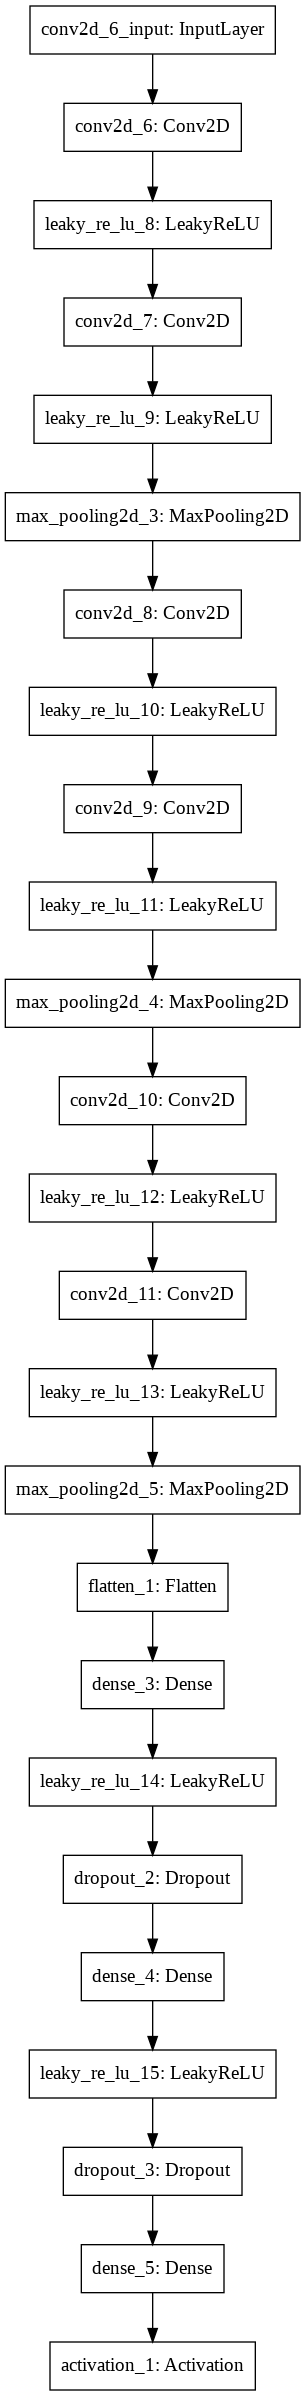

In [51]:
keras.utils.plot_model(model, "my_first_model.png")

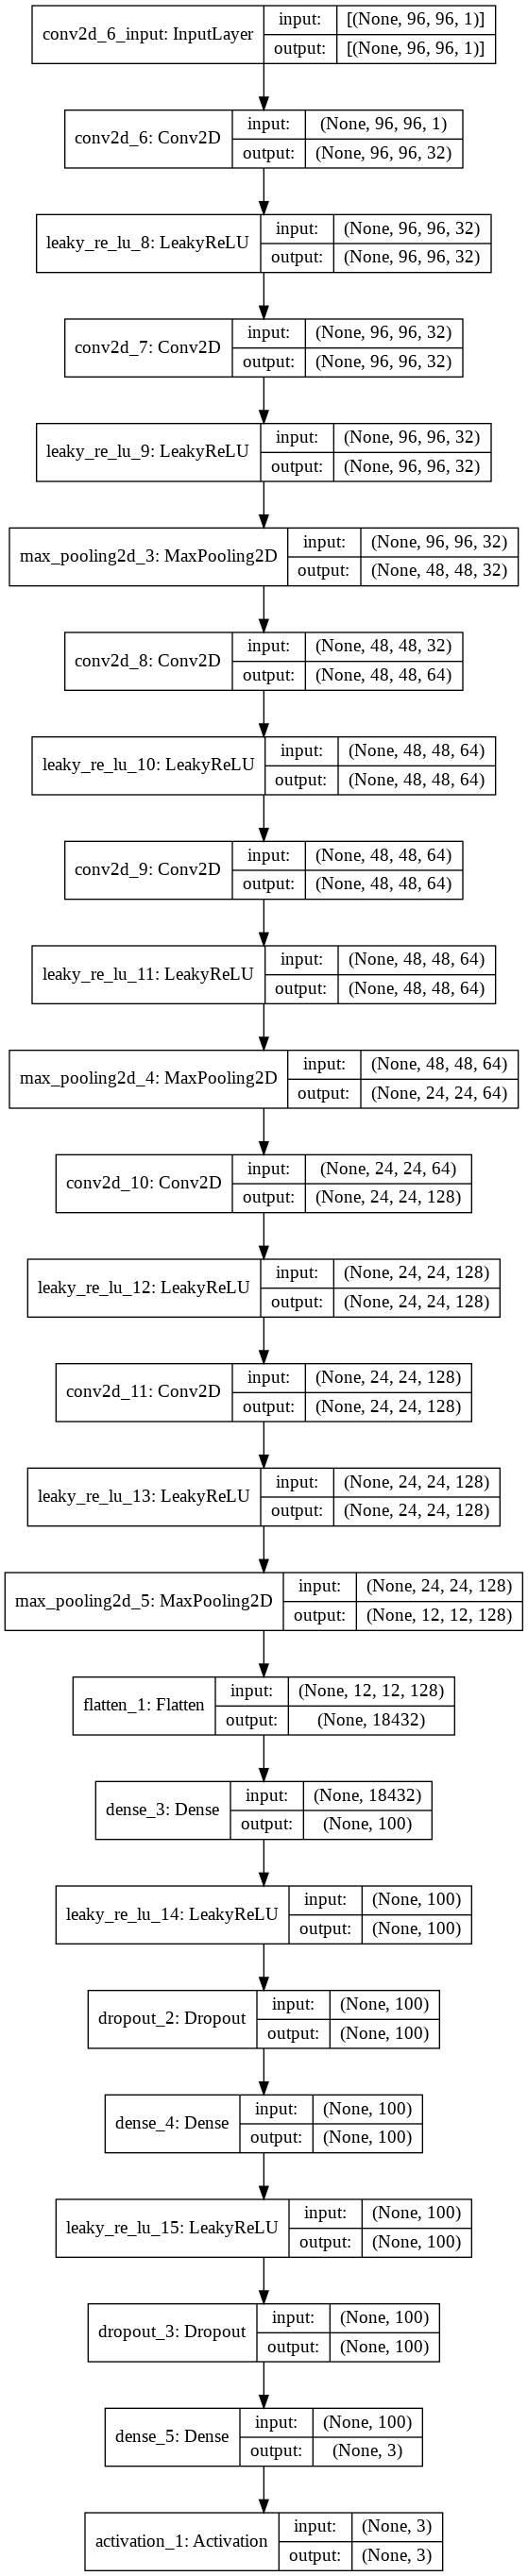

In [52]:
keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)

### 4.5.2 Training the CNN
The CNN is trained 3 times with 2 different train sets: *Source Domain* or the 12k CWRU DE data and *Transfer Domain* or the 10% MFPT. This is done with a validation set of 90% of the *Transfer or Target Domain* or the test of the *image batch size* and over 50 epochs. It will be then tested on the hold-out data (same test set). 

In [53]:
import tensorflow as tf
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=0, mode='auto')
# This callback will stop the training when there is no improvement in
# the loss for 10 consecutive epochs.

### Train 1
The Train Data is the *Source Domain* and the Validation is part of Test data or *Transfer/Target Domain*.


In [54]:
BATCH_SIZE = 80
NUMBER_OF_EPOCHS = 50

#callbacks=[callback]
history = model.fit(
    images_train_1, labels_train_1_onehot,
    batch_size=BATCH_SIZE,
    epochs=NUMBER_OF_EPOCHS,
    validation_data = (images_test, labels_test_onehot),
    validation_batch_size = 64,  
    verbose=1)

Epoch 1/50
74/74 [==============================] - 40s 82ms/step - loss: 2.7107 - categorical_accuracy: 0.5575 - val_loss: 1.4987 - val_categorical_accuracy: 0.3433
Epoch 2/50
74/74 [==============================] - 4s 59ms/step - loss: 0.2616 - categorical_accuracy: 0.9067 - val_loss: 1.6123 - val_categorical_accuracy: 0.3191
Epoch 3/50
74/74 [==============================] - 4s 59ms/step - loss: 0.1741 - categorical_accuracy: 0.9379 - val_loss: 1.7261 - val_categorical_accuracy: 0.3105
Epoch 4/50
74/74 [==============================] - 4s 59ms/step - loss: 0.1400 - categorical_accuracy: 0.9488 - val_loss: 1.9126 - val_categorical_accuracy: 0.3476
Epoch 5/50
74/74 [==============================] - 4s 60ms/step - loss: 0.1120 - categorical_accuracy: 0.9629 - val_loss: 1.9343 - val_categorical_accuracy: 0.3818
Epoch 6/50
74/74 [==============================] - 4s 60ms/step - loss: 0.1051 - categorical_accuracy: 0.9639 - val_loss: 2.2137 - val_categorical_accuracy: 0.3675
Epoch 7/5

### Train 1: Accuracy and Loss Curves

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


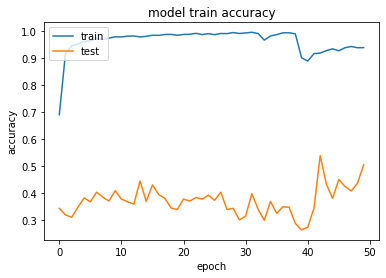

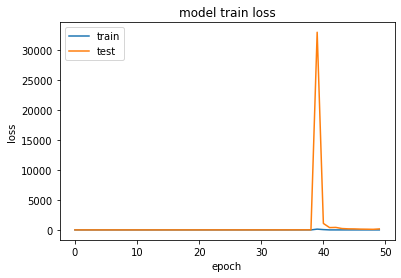

In [55]:
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Fine tuning for carrying on the second training

### Feature Extraction 
A **Transfer Learning** term where the CNN layers are frozen only and then the model is compiled 

In [56]:
# Freeze all layers except the last nine (Convolution)
for layer in model.layers[:-9]:
  layer.trainable = False

# It's important to recompile the model after any changes have been made
# to the `trainable` attribute of any inner layer, so that the changes
# are take into account 

model.compile(loss=LOSS_FUNCTION, 
              optimizer=keras.optimizers.Adam(1e-4),
              metrics=[metrics.categorical_accuracy])  
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 96, 96, 32)        320       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 96, 96, 32)        9248      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 96, 96, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 48, 48, 64)       

In [57]:
# Check the trainable status of the individual layers
for layer in model.layers:
  print(layer, layer.trainable)

<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc3300e7510> False
<tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x7fc330214290> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc3300b8c50> False
<tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x7fc330099850> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fc330024110> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc3300e16d0> False
<tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x7fc33006cd90> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc330020e10> False
<tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x7fc330029190> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fc330110810> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc33003ff10> False
<tensorflow.python.keras.

### Train 2 
The Train Data is now from the *Transfer/Target Domain*, the 10% train split of MFPT and the Validation remains the same, part of Test data or *Transfer/Target Domain*.

In [58]:
#train for less epochs as the dataset is now smaller
history = model.fit(images_train_2, labels_train_2_onehot, batch_size=BATCH_SIZE,
    epochs=NUMBER_OF_EPOCHS, 
    validation_data=(images_test, labels_test_onehot), 
    verbose=1)

Epoch 1/50
1/1 [==============================] - 1s 1s/step - loss: 249.2356 - categorical_accuracy: 0.5641 - val_loss: 160.5538 - val_categorical_accuracy: 0.5085
Epoch 2/50
1/1 [==============================] - 0s 228ms/step - loss: 250.5108 - categorical_accuracy: 0.5385 - val_loss: 156.5980 - val_categorical_accuracy: 0.5142
Epoch 3/50
1/1 [==============================] - 0s 221ms/step - loss: 290.1587 - categorical_accuracy: 0.5641 - val_loss: 152.8154 - val_categorical_accuracy: 0.5157
Epoch 4/50
1/1 [==============================] - 0s 218ms/step - loss: 218.4611 - categorical_accuracy: 0.4615 - val_loss: 149.2778 - val_categorical_accuracy: 0.5199
Epoch 5/50
1/1 [==============================] - 0s 219ms/step - loss: 218.8858 - categorical_accuracy: 0.4872 - val_loss: 145.8509 - val_categorical_accuracy: 0.5171
Epoch 6/50
1/1 [==============================] - 0s 222ms/step - loss: 227.9661 - categorical_accuracy: 0.4872 - val_loss: 142.5000 - val_categorical_accuracy: 0.

### Train 2: Accuracy and Loss Curves

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


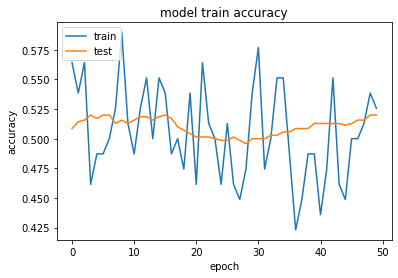

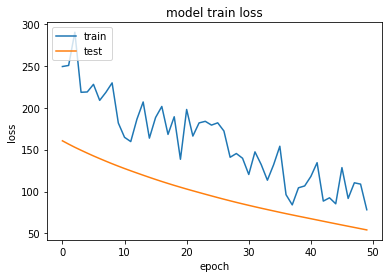

In [59]:
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Fine tuning
Another **Transfer Learning** term where now those CNN layers are unfrozen and then the model is compiled again

In [60]:
#Unfreeze all layers 
for layer in model.layers:
  layer.trainable = True

# It's important to recompile the model after any changes have been made
# to the `trainable` attribute of any inner layer, so that the changes
# are take into account 

model.compile(loss=LOSS_FUNCTION, 
              optimizer=keras.optimizers.Adam(1e-5),
              metrics=[metrics.categorical_accuracy])  
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 96, 96, 32)        320       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 96, 96, 32)        9248      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 96, 96, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 48, 48, 64)       

### Train 3 
The Train Data and the Validation remains the same as Train 2. 

In [62]:
#train for less epochs as the dataset is now smaller
history = model.fit(images_train_2, labels_train_2_onehot, batch_size=BATCH_SIZE,
    epochs=NUMBER_OF_EPOCHS, 
    validation_data=(images_test, labels_test_onehot), 
    verbose=1)

Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 104.9025 - categorical_accuracy: 0.5513 - val_loss: 52.9822 - val_categorical_accuracy: 0.5228
Epoch 2/50
1/1 [==============================] - 0s 261ms/step - loss: 97.0032 - categorical_accuracy: 0.4872 - val_loss: 51.8333 - val_categorical_accuracy: 0.5256
Epoch 3/50
1/1 [==============================] - 0s 257ms/step - loss: 85.2033 - categorical_accuracy: 0.5128 - val_loss: 50.7425 - val_categorical_accuracy: 0.5271
Epoch 4/50
1/1 [==============================] - 0s 259ms/step - loss: 92.5524 - categorical_accuracy: 0.5256 - val_loss: 49.7054 - val_categorical_accuracy: 0.5285
Epoch 5/50
1/1 [==============================] - 0s 258ms/step - loss: 80.2905 - categorical_accuracy: 0.3974 - val_loss: 48.7121 - val_categorical_accuracy: 0.5313
Epoch 6/50
1/1 [==============================] - 0s 257ms/step - loss: 89.4508 - categorical_accuracy: 0.5641 - val_loss: 47.7384 - val_categorical_accuracy: 0.5342
Epoch 

# 5.Test the CNN
Once the model has been fitted, the precision is calculated through a classical one vs many **confusion matrix**.

In [63]:
labels_predicted = np.argmax(history.model.predict(images_test), axis=-1)

In [64]:
# for the confusion matrix we need a factorized labels 
# [1,0,0] -> 0 ("N")
# [0,1,0] -> 1 ("IR")
# [0,0,1] -> 2 ("OR") 

labels_test_factorized = [(1*label[0]+2*label[1]+3*label[2])-1 for label in labels_test_onehot]

from sklearn.metrics import classification_report
print(classification_report(labels_test_factorized, labels_predicted))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       162
           1       0.47      0.80      0.59       189
           2       0.65      0.68      0.66       351

    accuracy                           0.55       702
   macro avg       0.37      0.49      0.42       702
weighted avg       0.45      0.55      0.49       702



#6. Final Train-Test loss and accuracy
Validation here is part of the test data.

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


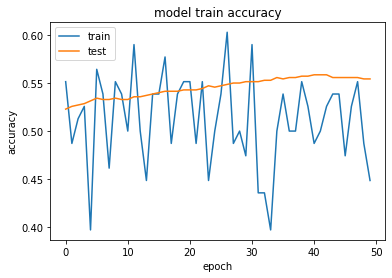

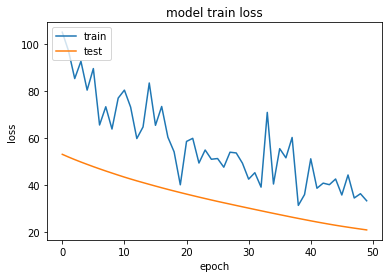

In [65]:
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# 7.ROC analysis
The ROC curves for each class give a complete picture of the classification performance of the CNN. The function below performs this task.

In [66]:
def ROC(model, X_test, y_test, n_class):
    import seaborn as sns
    from sklearn.metrics import roc_curve, roc_auc_score, auc
    from sklearn.metrics import confusion_matrix, classification_report
    from sklearn.metrics import accuracy_score, balanced_accuracy_score
    from sklearn.preprocessing import label_binarize
    from itertools import cycle
    import matplotlib.pyplot as plt
    import pandas as pd
    
    
    sns.set_style("dark",{"axes.facecolor": ".97"})
    # Predict the labels of the test set: y_pred
    y_pred = np.argmax(model.predict(X_test), axis=-1)

    # Compute predicted probabilities: y_pred_prob
    y_pred_prob = model.predict(X_test)
    y_test_binary = label_binarize(y_test, classes=range(0, n_class))

    y_test_normal = y_test_binary[:, 0]
    y_prob_normal = y_pred_prob[:, 0]

    y_test_inner_race = y_test_binary[:, 1]
    y_prob_inner_race = y_pred_prob[:, 1]

    y_test_outer_race = y_test_binary[:, 2]
    y_prob_outer_race = y_pred_prob[:, 2]
    
    lw = 1.5
    
    # Compute and print the confusion matrix and classification report
    matrix_c = confusion_matrix(y_test, y_pred)
    category_labels = ['N','IR','OR']

    matrix = pd.DataFrame(matrix_c)
    plt.figure()
    sns.heatmap(matrix, annot= True, fmt = "d",
           xticklabels = category_labels,
           yticklabels = category_labels, cmap = "Blues", cbar = False)
    plt.xticks(rotation = 90)
    plt.show()

    # Compute accuracy score
    print("accuracy score: ", accuracy_score(y_test, y_pred))
    print("Number of correctly Classified Samples: ", accuracy_score(y_test, y_pred, normalize=False))
    print("balanced accuracy score: ", balanced_accuracy_score(y_test, y_pred))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    thresholds = dict()
    roc_auc = dict()

    fpr[0], tpr[0], thresholds[0] = roc_curve(y_test_normal, y_prob_normal)
    fpr[1], tpr[1], thresholds[1] = roc_curve(y_test_inner_race, y_prob_inner_race)
    fpr[2], tpr[2], thresholds[2] = roc_curve(y_test_outer_race, y_prob_outer_race)

    for i in range(3):
      roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(4, 4), dpi=150)

    colors = ['black', 'red', 'green']
    plot_labels = ['N','IR','OR']
    for item in list(enumerate(colors)):
      # "N", "IR", "OR"
      plt.plot(fpr[item[0]], tpr[item[0]], color=item[1], lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                       ''.format(plot_labels[item[0]], roc_auc[item[0]]))

    plt.plot([0, 1], [0, 1], 'k--', lw=.7)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right", prop={'size': 8})
    plt.show()



### 7.1 ROC curve, Confusion matrix and accuracies

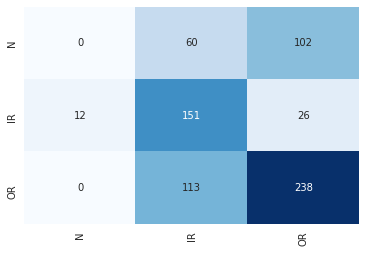

accuracy score:  0.5541310541310541
Number of correctly Classified Samples:  389
balanced accuracy score:  0.492334825668159


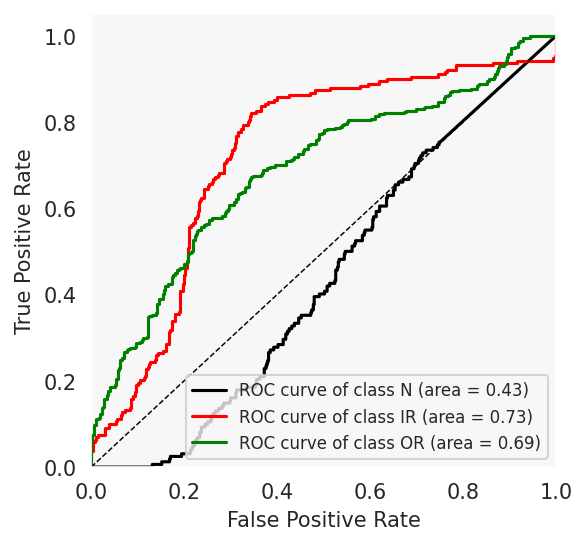

In [67]:
ROC(history.model, images_test, labels_test_factorized, 3)